<a href="https://colab.research.google.com/github/sgarg99/FacialExpressionClassification/blob/master/EmotionClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

In [2]:
!pip install -q tf-nightly

     |████████████████████████████████| 109.7MB 291kB/s 
     |████████████████████████████████| 491kB 41.0MB/s 
     |████████████████████████████████| 61kB 21.2MB/s 
     |████████████████████████████████| 3.1MB 29.4MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [78]:
cd gdrive/My Drive/Emotion_Classification/Training

/content/gdrive/My Drive/Emotion_Classification/Training


In [79]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()

tf.VERSION

'1.14.1-dev20190531'

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [81]:
import pathlib
data_root = "."
data_root = pathlib.Path(data_root)
print(data_root)

.


In [82]:
for item in data_root.iterdir():
  print(item)

2 (1)
1 (1)
4 (1)
6 (1)
5 (1)
3 (1)
0 (1)
model1.h5
model2.h5
my_model.h5
my_model1.h5


In [83]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

12971

In [84]:
all_image_paths[:10]

['3 (1)/Training_26861624.jpg',
 '5 (1)/Training_38603678.jpg',
 '5 (1)/Training_66625705.jpg',
 '6 (1)/Training_16366128.jpg',
 '6 (1)/Training_26849795.jpg',
 '6 (1)/Training_48211185.jpg',
 '4 (1)/Training_32555112.jpg',
 '6 (1)/Training_4424766.jpg',
 '0 (1)/Training_15108951.jpg',
 '0 (1)/Training_2721399.jpg']

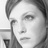

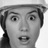

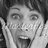

In [85]:
import IPython.display as display
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))

In [86]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['0 (1)', '1 (1)', '2 (1)', '3 (1)', '4 (1)', '5 (1)', '6 (1)']

In [87]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'0 (1)': 0,
 '1 (1)': 1,
 '2 (1)': 2,
 '3 (1)': 3,
 '4 (1)': 4,
 '5 (1)': 5,
 '6 (1)': 6}

In [88]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 5, 5, 6, 6, 6, 4, 6, 0, 0]


In [89]:
img_path = all_image_paths[0]
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=66580, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x...


In [90]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(48, 48, 1)
<dtype: 'uint8'>


In [0]:
img_final=tf.cast(img_tensor,tf.float32)
img_final=img_final/255.0

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=1)
  image = tf.image.resize_images(image, [48,48])
  image = tf.cast(image , tf.float32)
  image = image/255.0  # normalize to [0,1] range
  return image
  

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
mini_path_ds=tf.data.Dataset.from_tensor_slices(all_image_paths[:3500])

In [95]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
mini_image_ds =mini_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
mini_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels[:3500], tf.int64))


In [98]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

3 (1)
5 (1)
5 (1)
6 (1)
6 (1)
6 (1)
4 (1)
6 (1)
0 (1)
0 (1)


In [99]:
for path in path_ds.take(10):
  print(path)

tf.Tensor(b'3 (1)/Training_26861624.jpg', shape=(), dtype=string)
tf.Tensor(b'5 (1)/Training_38603678.jpg', shape=(), dtype=string)
tf.Tensor(b'5 (1)/Training_66625705.jpg', shape=(), dtype=string)
tf.Tensor(b'6 (1)/Training_16366128.jpg', shape=(), dtype=string)
tf.Tensor(b'6 (1)/Training_26849795.jpg', shape=(), dtype=string)
tf.Tensor(b'6 (1)/Training_48211185.jpg', shape=(), dtype=string)
tf.Tensor(b'4 (1)/Training_32555112.jpg', shape=(), dtype=string)
tf.Tensor(b'6 (1)/Training_4424766.jpg', shape=(), dtype=string)
tf.Tensor(b'0 (1)/Training_15108951.jpg', shape=(), dtype=string)
tf.Tensor(b'0 (1)/Training_2721399.jpg', shape=(), dtype=string)


In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
mini_image_label_ds=tf.data.Dataset.zip((mini_image_ds,mini_label_ds))

In [101]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (48, 48, 1)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int64)>


In [0]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds
mds=mini_image_label_ds.shuffle(buffer_size=1500)
mds=mds.repeat()
mds=mds.batch(BATCH_SIZE)
mds=mds.prefetch(buffer_size=AUTOTUNE)

In [0]:
inp_shp=(48,48,1)
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=inp_shp))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Dense(256,activation="relu"))
model.add(tf.keras.layers.Dense(256,activation="relu"))
model.add(tf.keras.layers.Dense(7,activation="softmax"))
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model.summary()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         2

In [0]:

mini_image_batch, mini_label_batch =next(iter(mds))
image_batch, label_batch=next(iter(ds))

In [35]:
steps_per_epoch=tf.ceil(3500/BATCH_SIZE).numpy()
steps_per_epoch


110.0

In [0]:
history=model.fit(mds, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10


W0530 16:17:41.976308 140244421883776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


47/47 [==============================] - 9s 192ms/step - loss: 1.8989 - acc: 0.1589
Epoch 2/10
47/47 [==============================] - 7s 146ms/step - loss: 1.8866 - acc: 0.1572
Epoch 3/10
47/47 [==============================] - 7s 147ms/step - loss: 1.8820 - acc: 0.1588
Epoch 4/10
47/47 [==============================] - 7s 146ms/step - loss: 1.8620 - acc: 0.1675
Epoch 5/10
47/47 [==============================] - 7s 148ms/step - loss: 1.8552 - acc: 0.1654
Epoch 6/10
47/47 [==============================] - 7s 147ms/step - loss: 1.8100 - acc: 0.1762
Epoch 7/10
47/47 [==============================] - 7s 147ms/step - loss: 1.7850 - acc: 0.1624
Epoch 8/10
47/47 [==============================] - 7s 146ms/step - loss: 1.7411 - acc: 0.1694
Epoch 9/10
47/47 [==============================] - 7s 147ms/step - loss: 1.7081 - acc: 0.1726
Epoch 10/10
47/47 [==============================] - 8s 166ms/step - loss: 1.6523 - acc: 0.1693


In [0]:
model.save("model1.h5")

W0530 10:31:51.964173 140631301216128 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


In [0]:
mini_image_batch, mini_label_batch =next(iter(mds))

In [0]:
inp_shp=(48,48,1)
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=inp_shp))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(48,(3,3),activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(7,activation="softmax"))

In [0]:

model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=0.1, epsilon=None, decay=0.0), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])


In [125]:
history=model.fit(mds, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
110/110 [==============================] - 24s 217ms/step - loss: 0.9040 - acc: 0.6597
Epoch 2/5
110/110 [==============================] - 23s 205ms/step - loss: 0.6771 - acc: 0.7491
Epoch 3/5
110/110 [==============================] - 23s 210ms/step - loss: 0.5408 - acc: 0.8026
Epoch 4/5
110/110 [==============================] - 23s 210ms/step - loss: 0.4320 - acc: 0.8477
Epoch 5/5
110/110 [==============================] - 23s 209ms/step - loss: 0.3439 - acc: 0.8724


dict_keys(['loss', 'acc'])


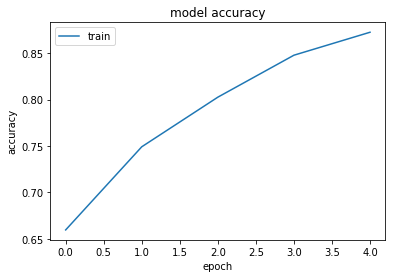

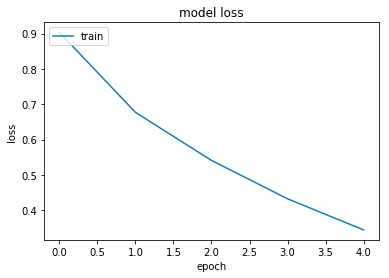

In [126]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
model.save("my_model5.h5")

In [122]:
history=model.fit(ds, epochs=10, steps_per_epoch=steps_per_epoch)


Epoch 1/10
110/110 [==============================] - 39s 358ms/step - loss: 1.4528 - acc: 0.4605
Epoch 2/10
110/110 [==============================] - 23s 213ms/step - loss: 1.4356 - acc: 0.4466
Epoch 3/10
110/110 [==============================] - 23s 212ms/step - loss: 1.4042 - acc: 0.4656
Epoch 4/10
110/110 [==============================] - 23s 211ms/step - loss: 1.3755 - acc: 0.4773
Epoch 5/10
110/110 [==============================] - 23s 211ms/step - loss: 1.2694 - acc: 0.5139
Epoch 6/10
110/110 [==============================] - 23s 213ms/step - loss: 1.2795 - acc: 0.5159
Epoch 7/10
110/110 [==============================] - 23s 210ms/step - loss: 1.3027 - acc: 0.4983
Epoch 8/10
110/110 [==============================] - 23s 210ms/step - loss: 1.1887 - acc: 0.5506
Epoch 9/10
110/110 [==============================] - 23s 210ms/step - loss: 1.1725 - acc: 0.5571
Epoch 10/10
110/110 [==============================] - 23s 209ms/step - loss: 1.1850 - acc: 0.5526


dict_keys(['loss', 'acc'])


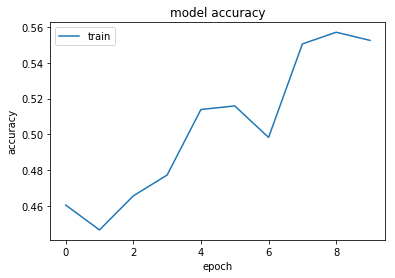

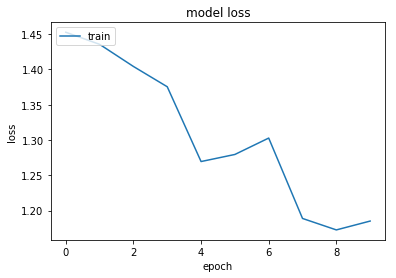

In [123]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
model.save("my_model4.h5")